# Segmentation model

To select circle-related pixels in an image containing several types of geometric shapes.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#Criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Dataset, B, V, C, Pipeline
from batchflow.models.tf import UNet
from batchflow.research import Results

from src import ShapesBatch, show_samples, show_loss, show_histogram, show_research

%env CUDA_VISIBLE_DEVICES='6,7'

env: CUDA_VISIBLE_DEVICES='6,7'


## Dataset

For training and model performance assessment we generate images of shape 128x128 on which a circle and a square are randomly located.
A size and a position of a figure are generated independently:

- A Circle's diameter 2$r$ and a side of a square 2$r$ are randomly sampled from [10, 48].
- A position of figure's center is randomly sampled from [$r$, 128 - $r$].

A label data for every image is a binary array of the same shape as an image with the value "1" if the corresponding pixel on the image represents circle and value "0" otherwise.

Data is generated on each iteration of training and test pipelines.
With respect to a number of iterations, there were generated 6000 images for training, 1000 images for testing.

Create a dataset as a template for a future generation of 1000 images:

In [2]:
imset = Dataset(1000, ShapesBatch)

Examples of dataset items (top row) and corresponding labels (bottom row):


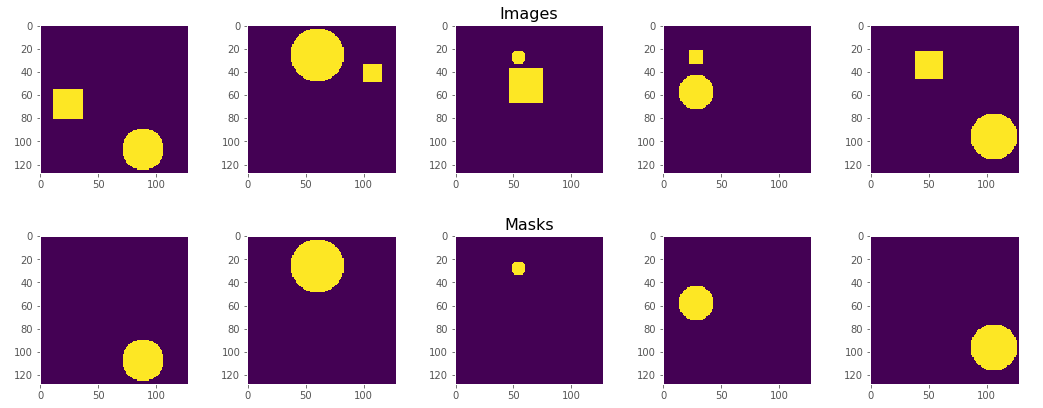

In [3]:
%matplotlib inline

NUM_IMAGES = 5
batch = imset.next_batch(NUM_IMAGES).sample_images(128, max_r=24)

show_samples([batch.images[:, :, :, 0], batch.masks[:, :, :, 0]], row_titles=["Images", "Masks"])

## Model architecture

We use UNet implemented in ```batchflow.models.tf```

An architecture specification can be found at [https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html)

Selected model configuration:
 * dimension of the input layer: [128, 128, 1]
 * dimension of the output layer: [128, 128, 1]
 * number of filters on the in-between layers: [12, 24, 48, 96].

Define a model config:

In [4]:
model_config={'inputs/images/shape': B('image_shape'),
              'inputs/masks/shape': B('image_shape'),
               'initial_block/inputs': 'images',
              
              'initial_block/filters': 12, 
              'body/encoder/num_stages': 3,
              'body/encoder/blocks/filters': [24, 48, 96], 
              'body/decoder/blocks/filters': [48, 24, 12],
              'head/filters': 12,
              
              'loss': 'bce',
              'optimizer': 'Adam',
              'output': ['sigmoid']
             }

## Selection of hyperparameters

The choice of this architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](https://github.com/analysiscenter/standards/blob/model/model_examples/classification_model/parameters_estimation.ipynb).

We conducted an [experiment](./parameters_estimation.ipynb) to study an impact of the initial number of filters in the network on the quality of the model (the subsequent layers have twice the number of filters in relation to the previous layer).

Due to the relative simplicity of the problem, only models with a small number of filters are investigated: - 4, 8, or 12 filters in the initial layer. Below are graphs for different numbers of the initial filters.

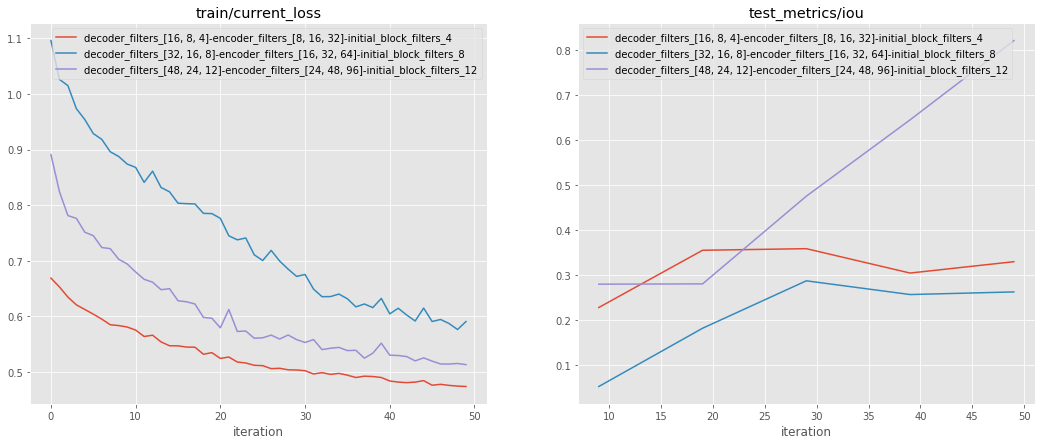

In [5]:
df = Results(path="parameters_research").load(use_alias=True)

show_research(df, layout=['train/current_loss', 'test_metrics/iou'], average_repetitions=True)

It can be concluded that a model with 12 filters on the initial layer learns much faster than models with a smaller number of filters and it makes sense to choose this value to solve the problem.

## Training

We train our model using stochastic gradient descent. On each iteration we
* load mini-batch data
* update the weights 

For weights update we used Adam with standard hyperparameters:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Loss function - cross-entropy.

Dataset bypass:
* ```batch_size``` = 20
* number of iterations = 300.

Training pipeline:

In [6]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list) 
                  .init_model('dynamic', UNet, 'unet', config=model_config)
                  .sample_images(128, max_r=24)
                  .train_model('unet', fetches='loss', images=B('images'), masks=B('masks'),
                               save_to=V('loss_history', mode='a')))

Execute training with batch size 20:

In [7]:
batch_size = 20

train_pipeline = (train_template << imset).run(batch_size, n_epochs=4, bar=True, workers=2, gpu=[6,7])

100%|██████████| 200/200 [14:36<00:00,  4.45s/it]


The loss function vs a number of iterations:

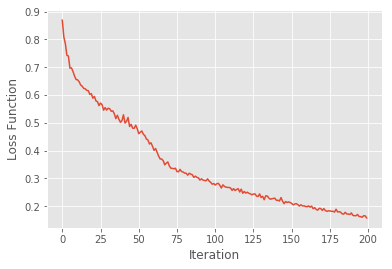

In [8]:
show_loss(train_pipeline.get_variable('loss_history'))

## Inference

Segmentation pipeline:

In [9]:
predict_template = (Pipeline()
                    .import_model('unet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list)
                    .predict_model('unet', fetches='sigmoid', images=B('images'),
                                   save_to=V('predictions', mode='e')))

Precreate data for segmentation:

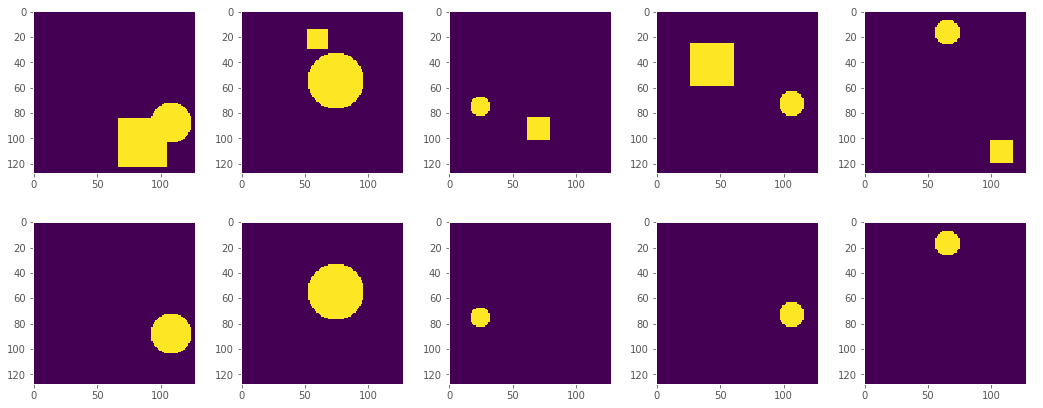

In [10]:
src_batch = (Dataset(NUM_IMAGES, ShapesBatch)
             .next_batch(NUM_IMAGES)
             .sample_images(128, circles=1, squares=1, max_r=24))

show_samples([src_batch.images[:, :, :, 0], src_batch.masks[:, :, :, 0]])

Execute segmetation pipeline:

In [11]:
predict_pipeline = ((predict_template << Dataset(NUM_IMAGES, ShapesBatch, preloaded=src_batch._data))
                    .run(5, shuffle=False, n_epochs=1, drop_last=False, bar=True))

100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Let's see the initial images and predicted masks

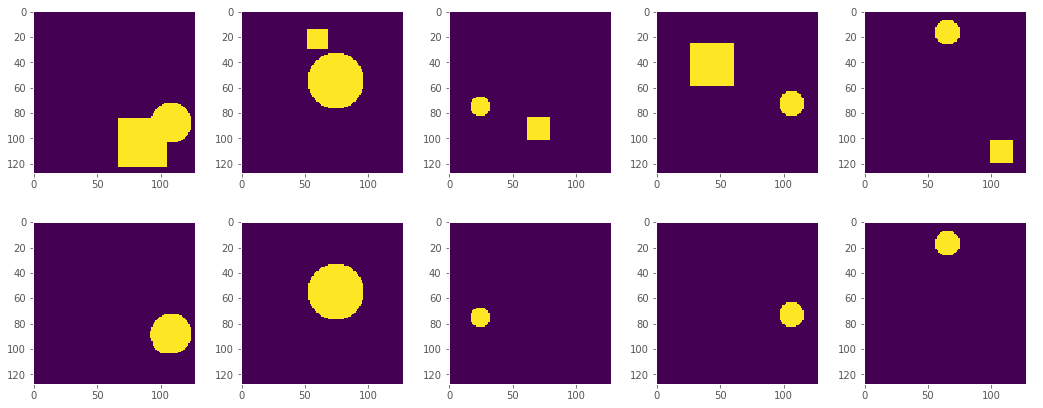

In [12]:
y_pred = np.rint(predict_pipeline.get_variable('predictions'))
show_samples([src_batch.images[:, :, :, 0], y_pred[:, :, :, 0]])

## Model evaluation

Quality metric, in this case, is the average value of the IOU metrics (intersection over union) on the test set containing of 1000 images.

Metric evaluation pipeline:

In [13]:
test_template = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('batch_predictions')
                 .init_variable('metrics', init_on_each_run=None)
                 .init_variable('images', init_on_each_run=list)
                 .init_variable('predictions', init_on_each_run=list)
                 .sample_images(128, circles=C('circles'), squares=C('squares'),
                                max_r=24, pixel_value=C('pixel_value'))
                 .update(V('images', mode='e'), B('images'))
                 .predict_model('unet', fetches='sigmoid', images=B('images'),
                                save_to=V('batch_predictions'))
                 .update(V('predictions', mode='e'), V('batch_predictions'))
                 .gather_metrics('segmentation',
                                 targets=B('masks'),
                                 predictions=V('batch_predictions'),
                                 fmt='proba',
                                 save_to=V('metrics', mode='u')))

Execute test pipeline:

In [14]:
test_pipeline = ((test_template << imset)
                 .set_config(dict(circles=1, squares=1, pixel_value=255))
                 .run(batch_size, shuffle=False, n_epochs=1, drop_last=False, bar=True))

print("IOU: %.3f" % test_pipeline.get_variable('metrics').evaluate('iou', agg='mean'))

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

IOU: 0.957


Examples of test images and predicted masks

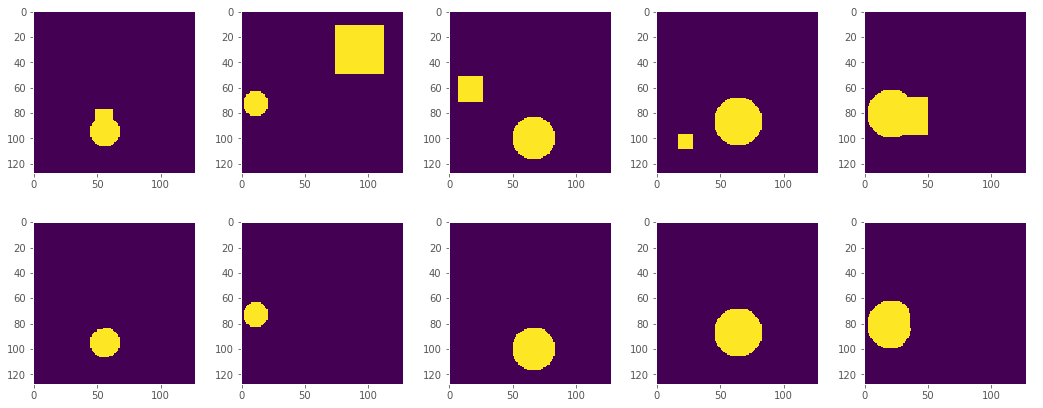

In [15]:
y_pred = np.rint(test_pipeline.get_variable('predictions'))
images = np.array(test_pipeline.get_variable('images'))

show_samples([images[:NUM_IMAGES, :, :, 0], y_pred[:NUM_IMAGES, :, :, 0]])

For model performance assessment an [experiment](./model_estimation.ipynb) was conducted on 20 model training launches from scratch.

Research results loading and a histogram for IOU metrics:

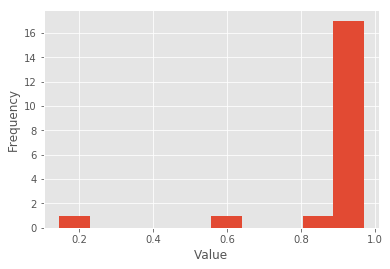

Average value (median): 0.955


In [16]:
df = Results(path='model_estimation_research').load(names='test_metrics')
values = df['iou'].values

show_histogram(values)
print('Average value (median): %.3f' % np.median(values))

## Operating time

Device: CPU i5.

One train step on batch size 20 takes 3.6 seconds. Training time is 18 minutes (300 iterations).

Inference for batch size 100 - 1.2 seconds.

## Criticism

The model was trained on examples containing one circle and one square. However, as the example below shows, the trained model can find an arbitrary number of circles in the image without a significant loss of accuracy (IOU = 0.93).

100%|██████████| 50/50 [00:28<00:00,  1.83it/s]


IOU: 0.929


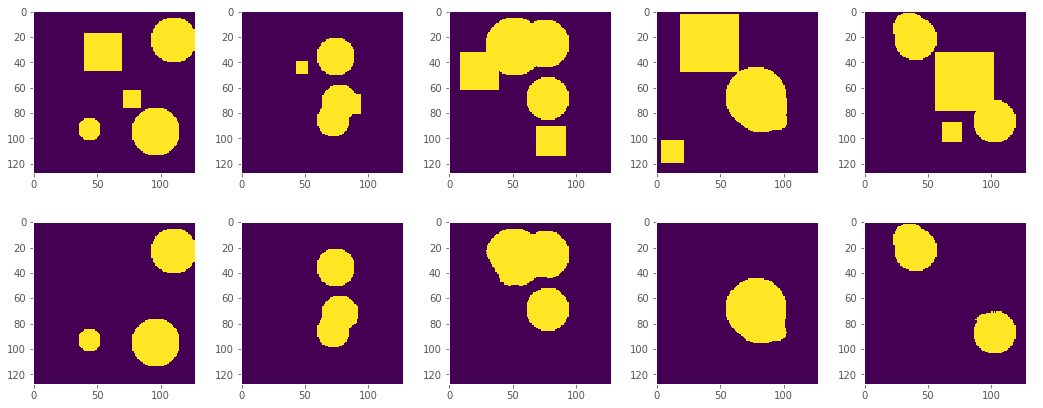

In [17]:
test_pipeline = ((test_template << imset)
                 .set_config(dict(circles=3, squares=2, pixel_value=255))
                 .run(batch_size, shuffle=False, n_epochs=1, drop_last=False, bar=True))

print("IOU: %.3f" % test_pipeline.get_variable('metrics').evaluate('iou', agg="mean"))

y_pred = np.rint(test_pipeline.get_variable('predictions'))
images = np.array(test_pipeline.get_variable('images'))
show_samples([images[:NUM_IMAGES, :, :, 0], y_pred[:NUM_IMAGES, :, :, 0]])

The model finds circles with a maximum pixel brightness. However, if the circles have different brightness, the accuracy decreases to IOU = 0.6. On the pictures below we can see model doesn't find circles with low pixel brightness.

100%|██████████| 50/50 [00:27<00:00,  1.74it/s]


IOU: 0.595


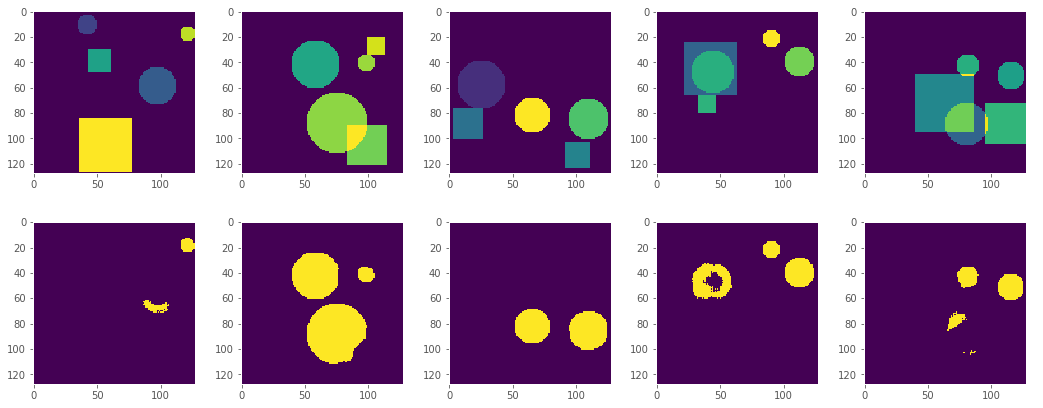

In [18]:
test_pipeline = ((test_template << imset)
                 .set_config(dict(circles=3, squares=2, pixel_value=None))
                 .run(batch_size, shuffle=False, n_epochs=1, drop_last=False, bar=True))

print("IOU: %.3f" % test_pipeline.get_variable('metrics').evaluate('iou', agg="mean"))

y_pred = np.rint(test_pipeline.get_variable('predictions'))
images = np.array(test_pipeline.get_variable('images'))
show_samples([images[:NUM_IMAGES, :, :, 0], y_pred[:NUM_IMAGES, :, :, 0]])

## Summary

Based on the generated dataset, the model learned how to select an arbitrary number of circles in an image with several types of geometric shapes. The average accuracy on the IOU metric based on 20 independent training cycles of the model was 0.955. The model was trained under the assumption that the figures have the same and, moreover, maximum pixel brightness. For figures with low low pixel brightness the model is not applicable.

## Proposals for the improvement and further development

To generalize the model, it makes sense to expand the diversity of the training sample by including examples of pictures with figures with different levels of contrast.